# Sprint 24 - Sequence to Sequence (Seq2Seq)

## Problem 1

In [1]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2020-08-06 18:11:37--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org... 2606:4700:3033::6818:6dc4, 2606:4700:3036::ac43:adc6, 2606:4700:3037::6818:6cc4, ...
Connecting to www.manythings.org|2606:4700:3033::6818:6dc4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6041598 (5.8M) [application/zip]
Saving to: 'fra-eng.zip'

fra-eng.zip         100%[===================>]   5.76M  2.77MB/s    in 2.1s    

2020-08-06 18:11:39 (2.77 MB/s) - 'fra-eng.zip' saved [6041598/6041598]



In [2]:
!unzip fra-eng.zip

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [4]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 23s 3ms/step - loss: 1.1686 - accuracy: 0.7259 - val_loss: 1.0475 - val_accuracy: 0.7077
Epoch 2/100
8000/8000 [==============================] - 24s 3ms/step - loss: 0.8590 - accuracy: 0.7674 - val_loss: 0.8469 - val_accuracy: 0.7610
Epoch 3/100
8000/8000 [==============================] - 22s 3ms/step - loss: 0.6898 - accuracy: 0.8052 - val_loss: 0.7191 - val_accuracy: 0.7934
Epoch 4/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.5992 - accuracy: 0.8263 - val_loss: 0.6546 - val_accuracy: 0.8098
Epoch 5/100
8000/8000 [==============================] - 22s 3ms/step - loss: 0.5480 - accuracy: 0.8405 - val_loss: 0.6113 - val_accuracy: 0.8217
Epoch 6/100
8000/8000 [==============================] - 

8000/8000 [==============================] - 23s 3ms/step - loss: 0.1115 - accuracy: 0.9652 - val_loss: 0.5463 - val_accuracy: 0.8744
Epoch 56/100
8000/8000 [==============================] - 24s 3ms/step - loss: 0.1091 - accuracy: 0.9659 - val_loss: 0.5464 - val_accuracy: 0.8742
Epoch 57/100
8000/8000 [==============================] - 24s 3ms/step - loss: 0.1069 - accuracy: 0.9666 - val_loss: 0.5510 - val_accuracy: 0.8754
Epoch 58/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.1046 - accuracy: 0.9671 - val_loss: 0.5616 - val_accuracy: 0.8742
Epoch 59/100
8000/8000 [==============================] - 24s 3ms/step - loss: 0.1026 - accuracy: 0.9678 - val_loss: 0.5660 - val_accuracy: 0.8739
Epoch 60/100
8000/8000 [==============================] - 25s 3ms/step - loss: 0.1002 - accuracy: 0.9685 - val_loss: 0.5663 - val_accuracy: 0.8738
Epoch 61/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.0982 - accuracy: 0.9690 - val_loss: 0.5711 - val_a

-
Input sentence: I left.
Decoded sentence: Je suis partie.

-
Input sentence: I left.
Decoded sentence: Je suis partie.

-
Input sentence: I lied.
Decoded sentence: J'ai perdu.

-
Input sentence: I lost.
Decoded sentence: J'ai perdu.

-
Input sentence: I paid.
Decoded sentence: J’ai payé.

-
Input sentence: I'm 19.
Decoded sentence: Je suis paresseuse.

-
Input sentence: I'm OK.
Decoded sentence: Je vais bien.

-
Input sentence: I'm OK.
Decoded sentence: Je vais bien.

-
Input sentence: Listen.
Decoded sentence: Écoutez !

-
Input sentence: No way!
Decoded sentence: Il n'en est pas questes !

-
Input sentence: No way!
Decoded sentence: Il n'en est pas questes !

-
Input sentence: No way!
Decoded sentence: Il n'en est pas questes !

-
Input sentence: No way!
Decoded sentence: Il n'en est pas questes !

-
Input sentence: No way!
Decoded sentence: Il n'en est pas questes !

-
Input sentence: No way!
Decoded sentence: Il n'en est pas questes !

-
Input sentence: No way!
Decoded sentence: 

**Let's summarize what each part of the above code does**

- **Lines 51-55:** Import library
- **Lines 57-62:** Setting hyperparameters
- **Lines 66-84:** the data is being vectorized, characters like alphabets and symbols that appear in the input and target texts are extracted. Read file. Use "\t" as the "start sequence" character. Use "\n" as "end sequence". The word list is sorted as well.
- **Lines 86-97:** we have here the number of samples given by the length of the inputed texts, the number of unique input and output tokens given respectively by the length of the inputed characters and targeted ones, and finally the max sequence length for inputs and outputs.
- **Lines 99-126:** Create a table corresponding to the encoder input and decoder input/output.
- **Lines 127-143:** Define a model that converts encoder_input_data and decoder_input_data to decoder_target_data, compile, train before saving. LSTM is used in both the encoder and decoder parts plus Dense for the decoder.
- **Lines 147-157:** Definition of the model, training and saving.
- **Lines 168-179:** Define of the sampling models The encoder and decoder models are defined.
- **Lines 183-186:** Reverse-lookup token index to decode sequences back to something readable.
- **Lines 189-224:** decode_sequence function for decoding a given inputed sequence.
- **Lines 227-234:** Showing results of a decoded sequence based on the inputed sequence.

## Problem 2

In [22]:
!git clone https://github.com/pdollar/coco.git
%cd coco/PythonAPI/
!make
!python setup.py build
!python setup.py install
%cd ../../
!git clone https://github.com/yunjey/pytorch-tutorial.git
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

Cloning into 'coco'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 1.09 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/Users/diopmouhamed/Desktop/DiveIntoCode_SummerInternship2019/MachineLearningCourse_2020/Deep_Learning_Sprints/coco/PythonAPI/coco/PythonAPI
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/diopmouhamed/Desktop/DiveIntoCode_SummerInternship2019/MachineLearningCourse_2020/Deep_Learning_Sprints/coco/PythonAPI/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating buil

Searching for matplotlib==3.1.1
Best match: matplotlib 3.1.1
Adding matplotlib 3.1.1 to easy-install.pth file

Using /Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages
Searching for Cython==0.29.13
Best match: Cython 0.29.13
Adding Cython 0.29.13 to easy-install.pth file
Installing cygdb script to /Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/bin
Installing cython script to /Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/bin
Installing cythonize script to /Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/bin

Using /Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages
Searching for setuptools==47.1.1
Best match: setuptools 47.1.1
Adding setuptools 47.1.1 to easy-install.pth file
Installing easy_install script to /Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/bin
Installing easy_install-3.8 script to /Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/bin

Using /Users/diopmouhamed/.pyenv/versions/anac

In [23]:
!pip install -r requirements.txt

In [7]:
!python sample.py --image='png/example.png'

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /Users/diopmouhamed/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
100%|████████████████████████████████████████| 230M/230M [00:50<00:00, 4.79MB/s]
<start> a group of giraffes standing next to each other . <end>


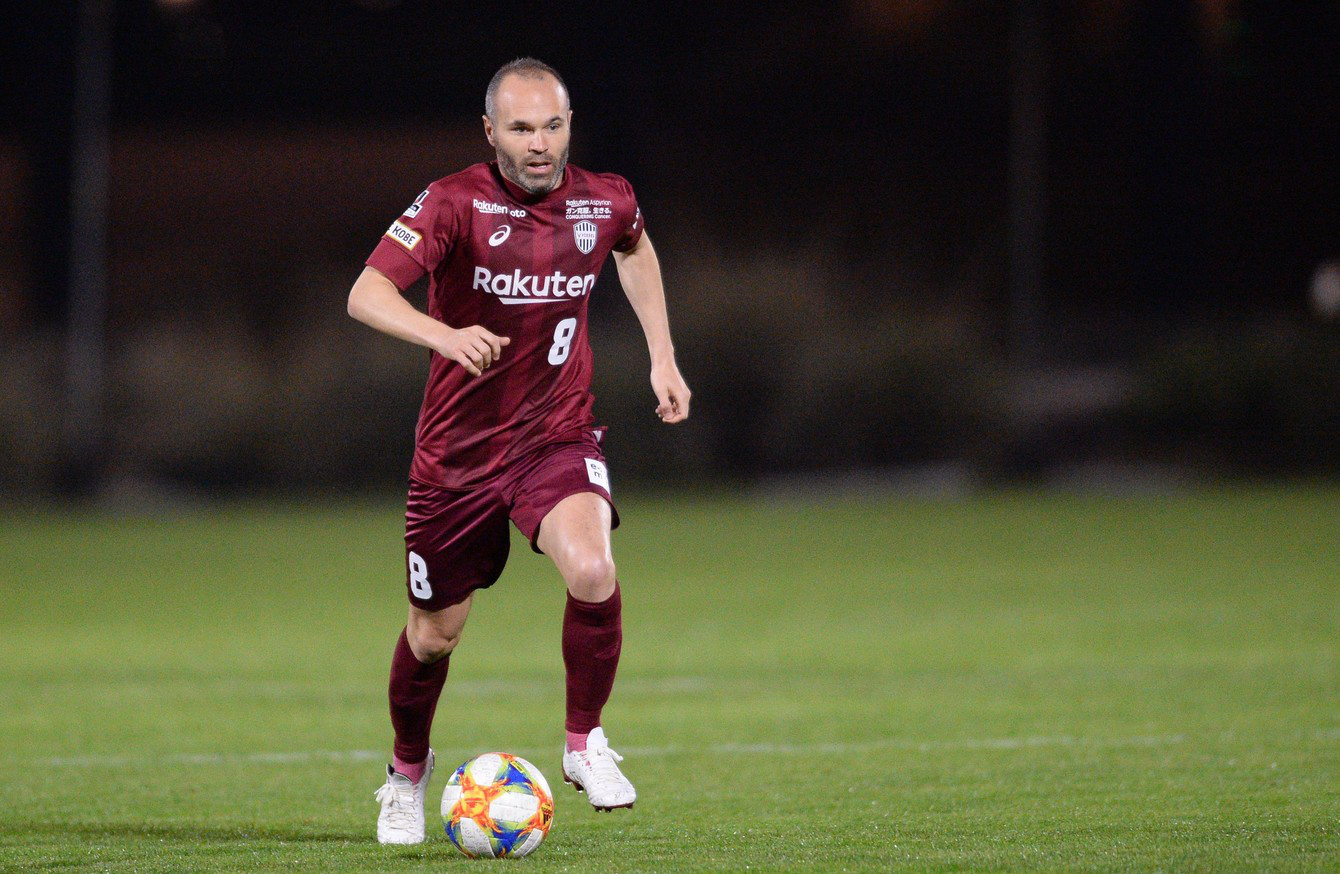

In [13]:
from PIL import Image
Image.open('./png/example2.png')

In [14]:
!python sample.py --image='png/example2.png'

<start> a man is playing with a soccer ball on a field . <end>


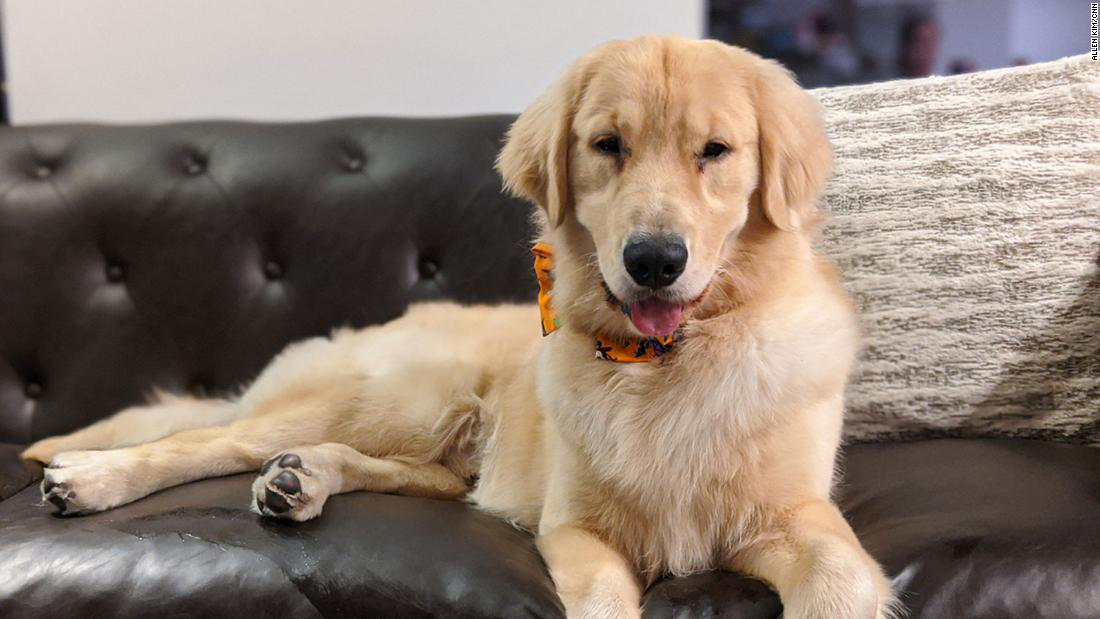

In [22]:
Image.open('./png/example3.png')

In [23]:
!python sample.py --image='png/example3.png'

<start> a dog is sitting on a couch with a remote . <end>


## Problem 3

A model for moving from Pytorch to Keras has already been defined (https://github.com/nerox8664/pytorch2keras), it can be used for the purpose of running the current implementation in Keras. A converter is availbale as define in the README, for converting from pytorch to keras. Then, after getting the Keras model, it can be saved as h5 file and then convert it with tensorflowjs_converter. FInally, when the output layer name is given, we do convertion from the_model.pb to tfjs model.

> - const MODEL_URL = `model_tfjs/tensorflowjs_model.pb`;
> - const WEIGHTS_URL = `model_tfjs/weights_manifest.json`;
> - const model = await tf.loadFrozenModel(MODEL_URL, WEIGHTS_URL);